<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/SBPFiniteDifferences_for_CoupledWaveHeatEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, the Finite Difference - SBP method is applied to the 1D wave and heat equations. These equations are first coupled using a fixed law and then through a neural network. We assume the condition where there is ample data on how the coefficient c of the wave equation varies as a function of c0 and temperature. The latter serves purely educational purposes, demonstrating how the numerical and neural components can be combined in practical use cases.

### Core Dependencies:
>numpy: 1.26.4  
matplotlib: 3.7.1  
IPython: 7.34.0  
tensorflow: 2.17.0  

In [ ]:
# @title Imports & helpers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image
import tensorflow as tf

def show_history_wo_T(filename, step=50, name='wave_sim'):
    """Generates a GIF animation of the time history for the 1D wave equation."""
    data = np.load(filename)
    x = data['x']
    history = data['history']

    fig, ax = plt.subplots(figsize=(12, 6))

    def update(frame):
        ax.clear()
        ax.plot(x, history[frame], label='Wave (u)', color='blue')
        ax.set_title(f"Time: {frame*step*dt:.2f}")
        ax.set_xlabel("x")
        ax.set_ylabel("Value")
        ax.legend()
        ax.set_ylim([np.min(history), np.max(history)])
        return ax,

    # Select frames with the given step size
    frames_to_save = len(history) // step + 1
    ani = FuncAnimation(fig, update, frames=range(0, len(history), step), repeat=False)
    ani.save(name + '.gif', writer=PillowWriter(fps=20))  # Use PillowWriter for GIF creation
    plt.close()


def show_history(filename, step=50, name='wave_sim'):
    """Generates a GIF animation of the time history."""
    data = np.load(filename)
    x = data['x']
    history_u = data['history_u']
    history_T = data['history_T']

    fig, ax = plt.subplots(figsize=(12, 6))

    def update(frame):
        ax.clear()
        ax.plot(x, history_u[frame], label='Wave (u)', color='blue')
        ax.plot(x, history_T[frame], label='Temperature (T)', color='red')
        ax.set_title(f"Time: {frame*dt:.2f}")
        ax.set_xlabel("x")
        ax.set_ylabel("Value")
        ax.legend()
        ax.set_ylim([min(np.min(history_u), np.min(history_T)), max(np.max(history_u), np.max(history_T))])
        return ax,

    # Select every 'step' frame
    frames_to_save = len(history_u) // step + 1
    ani = FuncAnimation(fig, update, frames=range(0, len(history_u), step), repeat=False)
    ani.save(name+'.gif', writer=PillowWriter(fps=20))  # Use PillowWriter
    plt.close()



#_______________________________________________________________________________
# CHECK PACKAGES VERSION:
#_______________________________________________________________________________
#import os
#packages = [
#    'numpy',
#    'matplotlib',
#    'IPython',
#    'tensorflow'
#]
#
#for package in packages:
#    try:
#        version = os.popen(f"pip show {package} | grep Version").read().strip().split(': ')[1]
#        print(f"{package}: {version}")
#    except Exception as e:
#        print(f"Error getting version for {package}: {e}")
#
#_______________________________________________________________________________
# THE FOLLOWING CODE WORKS PROPERLY WITH THESE PACKAGES VERSION:
#_______________________________________________________________________________
#numpy: 1.26.4
#matplotlib: 3.7.1
#IPython: 7.34.0
#tensorflow: 2.17.0
#_______________________________________________________________________________

# 1) SBP-SAT Method for 1D Wave Equation

## 1. Discretization of the 1D Wave Equation

The 1D wave equation is given by:
\begin{aligned}
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
\end{aligned}

Where:
- \( u(x, t) \) is the wave function.
- \( c \) is the wave speed.

## 2. Discretization Using SBP Operators

### 2.1. First Derivative Approximation (D1)

The first derivative of \( u \) with respect to \( x \) is approximated using a finite difference scheme:
\begin{aligned}
\frac{\partial u}{\partial x} \approx \frac{u_{i+1} - u_{i-1}}{2h}
\end{aligned}

Here, \( h \) is the spatial step size. The matrix \( D1 \) represents this first derivative operator:
\begin{aligned}
D1[i, i-1] = -\frac{1}{2h}
\end{aligned}
\begin{aligned}
D1[i, i+1] = \frac{1}{2h}
\end{aligned}

Boundary points are treated separately to enforce boundary conditions.

### 2.2. Second Derivative Approximation (D2)

The second derivative of \( u \) with respect to \( x \) is approximated as:
\begin{aligned}
\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}
\end{aligned}

The matrix \( D2 \) represents this second derivative operator:
\begin{aligned}
D2[i, i-1] = \frac{1}{h^2}
\end{aligned}
\begin{aligned}
D2[i, i] = -\frac{2}{h^2}
\end{aligned}
\begin{aligned}
D2[i, i+1] = \frac{1}{h^2}
\end{aligned}

## 3. Stabilization Using SAT (Summation-By-Parts with Stabilization)

### 3.1. Boundary Conditions

To enforce Dirichlet boundary conditions \( u(0, t) = 0 \) and \( u(L, t) = 0 \) (where \( L \) is the domain length), the SAT method modifies the time derivatives at the boundaries.

Let \(tau \) be the stabilization parameter. The SAT term modifies the time derivative du/dt at the boundaries:
\begin{aligned}
\frac{du}{dt} \text{ at } x = 0: \quad du_{dt}[0] \leftarrow du_{dt}[0] - \frac{\tau u[0]}{H[0,0]}
\end{aligned}
\begin{aligned}
\frac{du}{dt} \text{ at } x = L: \quad du_{dt}[-1] \leftarrow du_{dt}[-1] - \frac{\tau u[-1]}{H[-1,-1]}
\end{aligned}

Where \( H \) is a weight matrix.

### 3.2. Time Derivatives Adjustment

The boundary adjustments also set the time derivative of the second derivative dp/dt to zero at the boundaries:
\begin{aligned}
\frac{dp}{dt} \text{ at } x = 0: \quad dp_{dt}[0] = 0
\end{aligned}
\begin{aligned}
\frac{dp}{dt} \text{ at } x = L: \quad dp_{dt}[-1] = 0
\end{aligned}

## Summary

The SBP-SAT method applies finite difference approximations to discretize the spatial derivatives and uses the SAT technique to enforce boundary conditions and stabilize the numerical scheme. The key steps involve:
1. Constructing SBP matrices \( D1 \) and \( D2 \).
2. Applying SAT to adjust boundary conditions and stabilize the solution.
3. Integrating the system in time, typically using methods like Runge-Kutta.


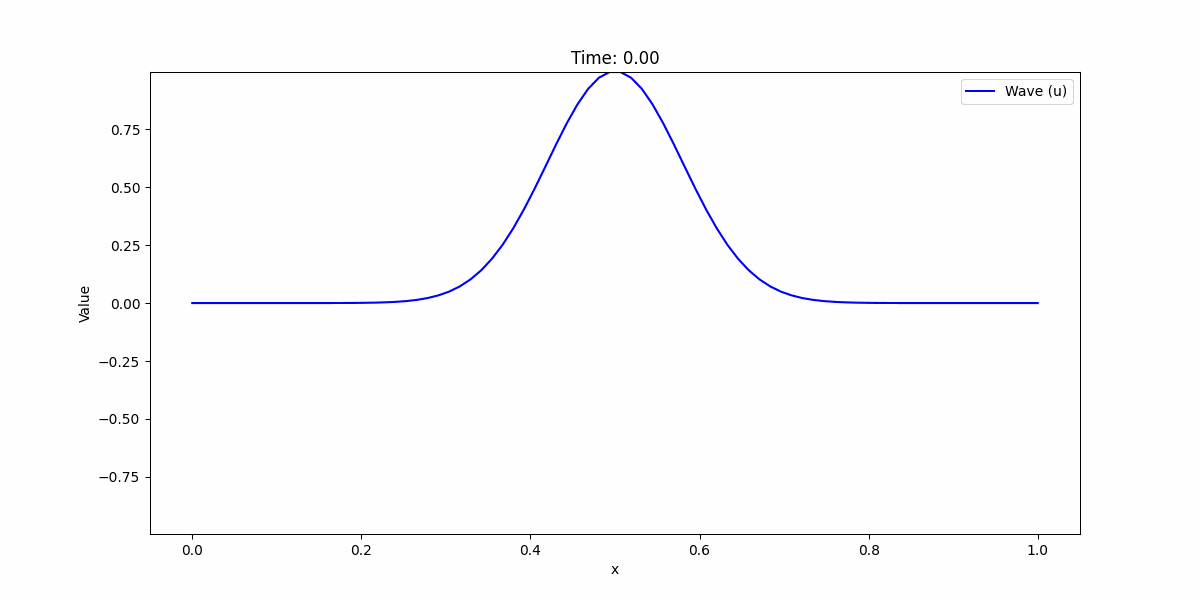

In [ ]:
# @title SBP-SAT Method for 1D Wave Equation Code



def sbp_matrix(N, h):
    """Constructs the SBP matrices D1 and D2 for a grid with N points and step size h."""
    e = np.ones(N)

    # First derivative D1 (2nd order)
    D1 = np.diag(-1*e[:-1], -1) + np.diag(e[:-1], 1)
    D1[0, 0] = -1; D1[0, 1] = 1; D1[-1, -2] = -1; D1[-1, -1] = 1
    D1 = D1 / (2 * h)

    # Second derivative D2 (2nd order)
    D2 = np.diag(-2*e) + np.diag(e[:-1], 1) + np.diag(e[:-1], -1)
    D2 = D2 / (h**2)

    # Weight matrix H for energy
    H = h * np.eye(N)

    return D1, D2, H

def wave_equation_system(u, p, c, D1, D2):
    """Computes the time derivatives for the wave equation system."""
    du_dt = p
    dp_dt = c**2 * (D2 @ u)

    return du_dt, dp_dt

def apply_sat(du_dt, dp_dt, u, H, tau):
    """Applies the SAT method to enforce boundary conditions."""
    # Dirichlet condition at u(0,t) and u(L,t)
    du_dt[0]  = du_dt[0]  - tau * u[0]  / H[0,0]
    du_dt[-1] = du_dt[-1] - tau * u[-1] / H[-1,-1]

    # Set dp_dt to zero at the boundaries
    dp_dt[0]  = 0
    dp_dt[-1] = 0

    return du_dt, dp_dt

def rk4_step(u, p, dt, c, D1, D2, H, tau):

    k1_u, k1_p = wave_equation_system(u, p, c, D1, D2)
    k1_u, k1_p = apply_sat(k1_u, k1_p, u, H, tau)

    u2 = u + 0.5 * dt * k1_u
    p2 = p + 0.5 * dt * k1_p

    k2_u, k2_p = wave_equation_system(u2, p2, c, D1, D2)
    k2_u, k2_p = apply_sat(k2_u, k2_p, u2, H, tau)

    u3 = u + 0.5 * dt * k2_u
    p3 = p + 0.5 * dt * k2_p

    k3_u, k3_p = wave_equation_system(u3, p3, c, D1, D2)
    k3_u, k3_p = apply_sat(k3_u, k3_p, u3, H, tau)

    u4 = u + dt * k3_u
    p4 = p + dt * k3_p

    k4_u, k4_p = wave_equation_system(u4, p4, c, D1, D2)
    k4_u, k4_p = apply_sat(k4_u, k4_p, u4, H, tau)

    u_new = u + (dt/6) * (k1_u + 2*k2_u + 2*k3_u + k4_u)
    p_new = p + (dt/6) * (k1_p + 2*k2_p + 2*k3_p + k4_p)

    return u_new, p_new


#-------------------------------------------------------------------------------

# Problem parameters
N    = 80   # Number of points in the grid
L    = 1.0  # Length of the domain
h    = L / (N-1)  # Spatial step size
c    = 0.2   # Wave speed coefficient
# Spatial grid
x = np.linspace(0, L, N)

tau  = 0.1   # SAT parameter
dt   = 0.001 # Time step
T    = 10    # Final time

# Initial conditions
mean = 0.5  # Center of the Gaussian
std_dev = 0.08  # Standard deviation of the Gaussian
u = np.exp(-((x - mean)**2) / (2 * std_dev**2))
p = np.zeros(N)  # Initial velocity is zero


#-------------------------------------------------------------------------------

# Compute SBP matrices
D1, D2, H = sbp_matrix(N, h)

history = []

t = 0
while t < T:
    history.append(u.copy())
    u, p = rk4_step(u, p, dt, c, D1, D2, H, tau)
    t += dt

np.savez('wave_simulation_history.npz', x=x, history=np.array(history))

show_history_wo_T('wave_simulation_history.npz', step=50, name='wave_simulation')
Image(filename='wave_simulation.gif')


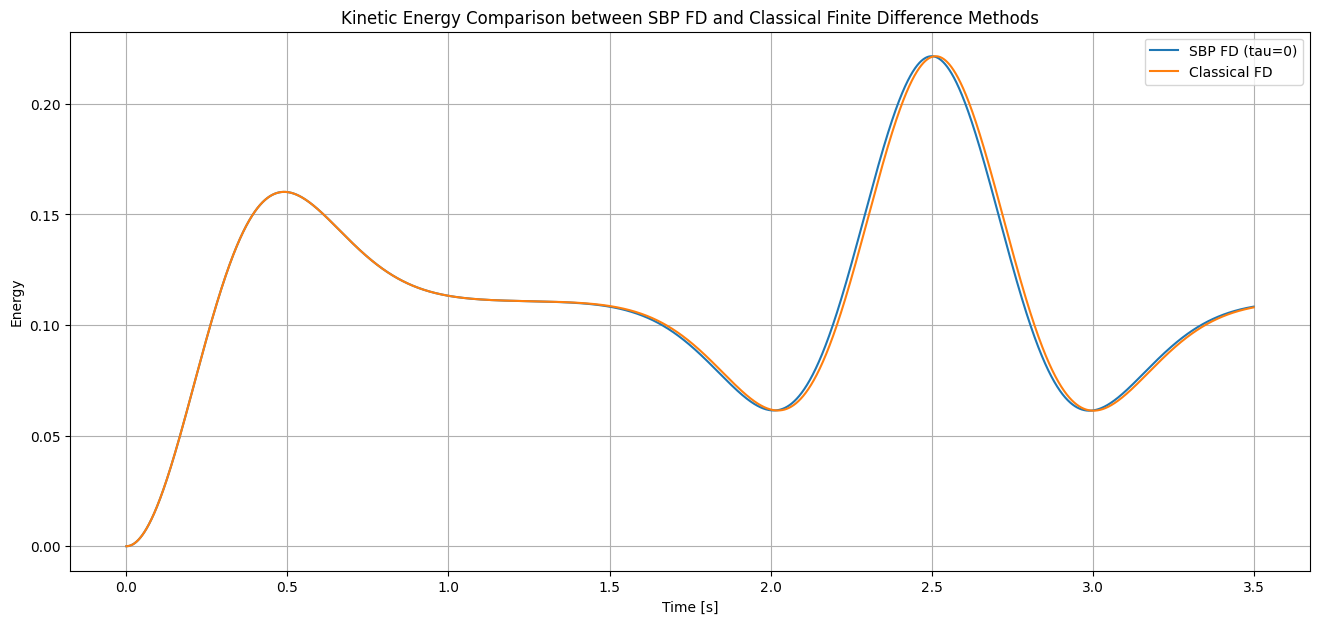

In [ ]:
# @title SBP-SAT Method vs Classic Finite Difference - Energy Comparison

# Function to compute energy
def compute_energy(u, p, H):
    return 0.5 * (np.dot(p, H @ p)) #+ np.dot(u, H @ u))

# Traditional Finite Difference Derivatives
def fd_derivatives(N, h):
    e = np.ones(N)
    D1 = np.diag(-1*e[:-1], -1) + np.diag(e[:-1], 1)
    D1 = D1 / (2 * h)

    D2 = np.diag(-2*e) + np.diag(e[:-1], 1) + np.diag(e[:-1], -1)
    D2 = D2 / (h**2)

    return D1, D2

# RK4 integration step for traditional FD
def rk4_fd_step(u, p, dt, c, D1, D2):
    k1_u, k1_p = wave_equation_system(u, p, c, D1, D2)
    u2 = u + 0.5 * dt * k1_u
    p2 = p + 0.5 * dt * k1_p

    k2_u, k2_p = wave_equation_system(u2, p2, c, D1, D2)
    u3 = u + 0.5 * dt * k2_u
    p3 = p + 0.5 * dt * k2_p

    k3_u, k3_p = wave_equation_system(u3, p3, c, D1, D2)
    u4 = u + dt * k3_u
    p4 = p + dt * k3_p

    k4_u, k4_p = wave_equation_system(u4, p4, c, D1, D2)

    u_new = u + (dt/6) * (k1_u + 2*k2_u + 2*k3_u + k4_u)
    p_new = p + (dt/6) * (k1_p + 2*k2_p + 2*k3_p + k4_p)

    return u_new, p_new

# Initialize variables for comparison
N    = 400
L    = 1.0
h    = L / (N-1)
c    = 0.2
tau  = 0.0
dt   = 0.0001
T    = 3.5

x = np.linspace(0, L, N)
mean = 0.5
std_dev = 0.08
u_init = np.exp(-((x - mean)**2) / (2 * std_dev**2))
p_init = np.zeros(N)

# SBP-SAT matrices
D1_sbp, D2_sbp, H = sbp_matrix(N, h)

# FD matrices
D1_fd, D2_fd = fd_derivatives(N, h)

# Store energy
energy_sbp = []
energy_fd  = []

u_sbp, p_sbp = u_init.copy(), p_init.copy()
u_fd, p_fd   = u_init.copy(), p_init.copy()

# Time-stepping loop
t = 0
while t < T:
    # Perform SBP-SAT step
    u_sbp, p_sbp = rk4_step(u_sbp, p_sbp, dt, c, D1_sbp, D2_sbp, H, tau)

    # Perform FD step
    u_fd, p_fd = rk4_fd_step(u_fd, p_fd, dt, c, D1_fd, D2_fd)

    # Compute and store energy after each time step
    energy_sbp.append(compute_energy(u_sbp, p_sbp, H))
    energy_fd.append(compute_energy(u_fd, p_fd, np.eye(N) * h))

    t += dt

# Correct time axis to match the number of energy steps
time = np.arange(0, T, dt)[:len(energy_sbp)]

# Plotting Energy
plt.figure(figsize=(16, 7))
plt.plot(time, energy_sbp, label="SBP FD (tau=0)")
plt.plot(time, energy_fd,  label="Classical FD")
plt.xlabel("Time [s]")
plt.ylabel("Energy")
plt.title("Kinetic Energy Comparison between SBP FD and Classical Finite Difference Methods")
plt.legend()
plt.grid(True)
plt.show()


# 2) Coupled 1D Wave and Heat Equations

### Overview

We consider a system of coupled partial differential equations (PDEs) involving a 1D wave equation and a 1D heat equation. The wave speed is influenced by the temperature field, making the problem nonlinear. The numerical solution uses the Summation-By-Parts (SBP) method to discretize the PDEs and enforce boundary conditions.

### 1. Summation-By-Parts (SBP) Method

The SBP method provides a way to discretize differential operators while preserving important properties such as stability and accuracy. In this case, we use it to handle the spatial discretization of the wave and heat equations.

#### 1.1 Discretization Matrices

- **First Derivative Matrix (`D1`)**:
  The first derivative of a function \( u(x) \) is approximated using a second-order accurate finite difference scheme. The matrix `D1` represents this derivative:
  
  \begin{aligned}
  D1_{ij} = \begin{cases}
  \frac{-1}{2h} & \text{if } j = i+1 \\
  \frac{1}{2h} & \text{if } j = i-1 \\
  0 & \text{otherwise}
  \end{cases}
  \end{aligned}

  Boundary conditions are enforced explicitly:
  
  \begin{aligned}
  D1[0,0] &= -1, \quad D1[0,1] = 1 \\
  D1[N-1, N-2] &= -1, \quad D1[N-1, N-1] = 1
  \end{aligned}
  
  where \( h \) is the spatial step size.

- **Second Derivative Matrix (`D2`)**:
  The second derivative of a function \( u(x) \) is approximated using:
  
  \begin{aligned}
  D2_{ij} = \begin{cases}
  \frac{-2}{h^2} & \text{if } i = j \\
  \frac{1}{h^2} & \text{if } j = i\pm1 \\
  0 & \text{otherwise}
  \end{cases}
  \end{aligned}
  

- **Weight Matrix (`H`)**:
  The weight matrix for energy computation is:
  
  \begin{aligned}
  H_{ii} = h
  \end{aligned}

### 2. PDEs

#### 2.1 Wave Equation

The 1D wave equation is given by:

\begin{aligned}
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
\end{aligned}


where \( u(x,t) \) is the wave field, and \( c \) is the wave speed. The time derivatives are computed as:

\begin{aligned}
\frac{\partial u}{\partial t} &= p \\
\frac{\partial p}{\partial t} &= c^2 \left( D2 \cdot u \right)
\end{aligned}

#### 2.2 Heat Equation

The 1D heat equation is given by:

\begin{aligned}
\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2}
\end{aligned}

where \( T(x,t) \) is the temperature field, and \( \alpha \) is the thermal diffusivity. The time derivative is:

\begin{aligned}
\frac{\partial T}{\partial t} = \alpha \left( D2 \cdot T \right)
\end{aligned}

### 3. Coupling of Wave Speed

The wave speed \( c \) depends on the temperature \( T \):

\begin{aligned}
c(T) = c_0 \left(1 + k T \right)
\end{aligned}

where \( c_0 \) is the base wave speed, and \( k \) is a coupling constant. This relationship adjusts the wave speed based on the local temperature field.

### 4. Time Integration Using RK4

The Runge-Kutta 4th-order (RK4) method is used to integrate the time derivatives of the wave and heat equations. The steps involve:

1. **Compute Time Derivatives**:
   - For the wave equation:
       
     \begin{aligned}
     k1_u, k1_p &= \text{wave_equation_system}(u, p, c, D1, D2) \\
     k2_u, k2_p &= \text{wave_equation_system}(u2, p2, c2, D1, D2) \\
     k3_u, k3_p &= \text{wave_equation_system}(u3, p3, c3, D1, D2) \\
     k4_u, k4_p &= \text{wave_equation_system}(u4, p4, c4, D1, D2)
     \end{aligned}
       
   - For the heat equation:  
     \begin{aligned}
     k1_T, k2_T, k3_T, k4_T = \text{heat_equation_system}(T, \alpha, D2)
     \end{aligned}

2. **Update Solutions**:
   - The updated solutions are computed using:
     
     \begin{aligned}
     u_{\text{new}} &= u + \frac{dt}{6} (k1_u + 2k2_u + 2k3_u + k4_u) \\
     p_{\text{new}} &= p + \frac{dt}{6} (k1_p + 2k2_p + 2k3_p + k4_p) \\
     T_{\text{new}} &= T + \frac{dt}{6} (k1_T + 2k2_T + 2k3_T + k4_T)
     \end{aligned}
     

### 5. Boundary Conditions

The boundary conditions are enforced using the SAT (Summation-By-Parts with Stabilization) method:

- **Dirichlet Condition for `u`**:
  
  \begin{aligned}  
  du\_dt[0] = du\_dt[0] - \frac{\tau u[0]}{H[0,0]}
  \end{aligned}
  
  
  \begin{aligned}   
  du\_dt[-1] = du\_dt[-1] - \frac{\tau u[-1]}{H[-1,-1]}
  \end{aligned}
  

- **Zero Velocity at Boundaries**:

  \begin{aligned}     
  dp\_dt[0] = 0
  \end{aligned}

  \begin{aligned}     
  dp\_dt[-1] = 0
  \end{aligned}

### Summary

The coupled system of the 1D wave and heat equations is solved using the SBP method for spatial discretization and the RK4 method for time integration. The wave speed is dynamically updated based on the temperature field, allowing for a comprehensive simulation of the coupled phenomena.


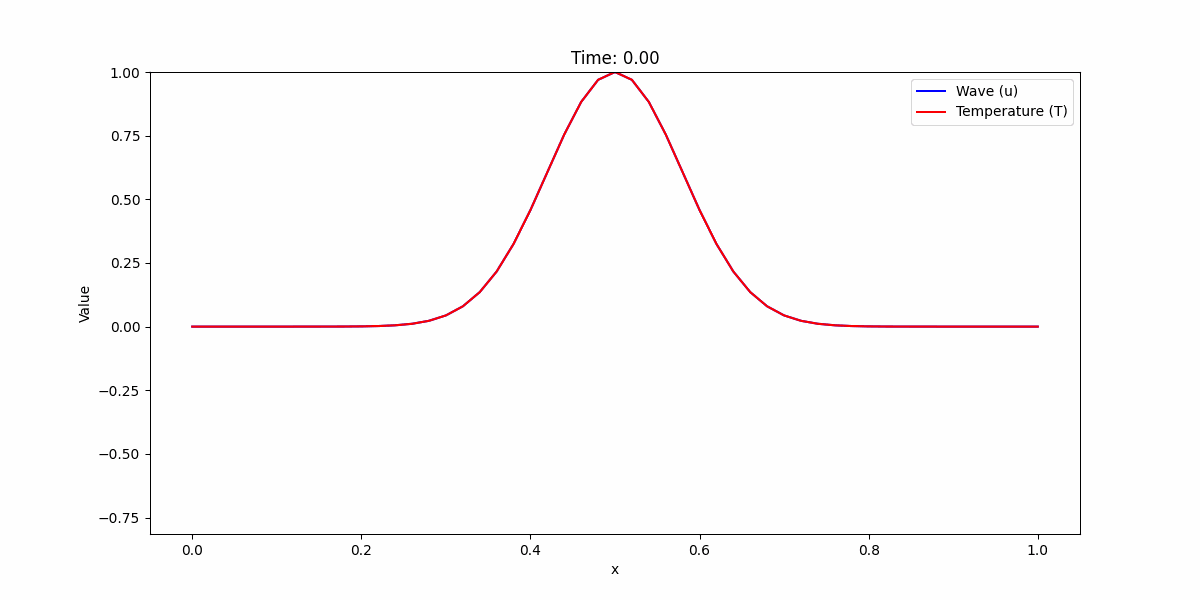

In [ ]:
# @title Coupled 1D Wave and Heat Equations Code


def sbp_matrix(N, h):
    """Constructs the SBP matrices D1 and D2 for a grid with N points and step size h."""
    e = np.ones(N)

    # First derivative D1 (2nd order)
    D1 = np.diag(-1*e[:-1], -1) + np.diag(e[:-1], 1)
    D1[0, 0] = -1; D1[0, 1] = 1; D1[-1, -2] = -1; D1[-1, -1] = 1
    D1 = D1 / (2 * h)

    # Second derivative D2 (2nd order)
    D2 = np.diag(-2*e) + np.diag(e[:-1], 1) + np.diag(e[:-1], -1)
    D2 = D2 / (h**2)

    # Weight matrix H for energy
    H = h * np.eye(N)

    return D1, D2, H

def wave_equation_system(u, p, c, D1, D2):
    """Computes the time derivatives for the wave equation system."""
    du_dt = p
    dp_dt = c**2 * (D2 @ u)

    return du_dt, dp_dt

def heat_equation_system(T, alpha, D2):
    """Computes the time derivatives for the heat equation system."""
    dT_dt = alpha * (D2 @ T)

    return dT_dt

def update_wave_speed(T, c0, k):
    """Updates the wave speed based on the temperature."""

    c_corr = c0 * (1 + k * T)
    #print((c_corr))

    return c_corr

def rk4_step_wave_heat(u, p, T, dt, c0, alpha, k, D1, D2, H, tau):
    """Performs one Runge-Kutta 4th order time step for coupled wave and heat equations."""
    c = update_wave_speed(T, c0, k)

    k1_u, k1_p = wave_equation_system(u, p, c, D1, D2)
    k1_u, k1_p = apply_sat(k1_u, k1_p, u, H, tau)

    k1_T = heat_equation_system(T, alpha, D2)

    u2 = u + 0.5 * dt * k1_u
    p2 = p + 0.5 * dt * k1_p
    T2 = T + 0.5 * dt * k1_T

    c2 = update_wave_speed(T2, c0, k)

    k2_u, k2_p = wave_equation_system(u2, p2, c2, D1, D2)
    k2_u, k2_p = apply_sat(k2_u, k2_p, u2, H, tau)

    k2_T = heat_equation_system(T2, alpha, D2)

    u3 = u + 0.5 * dt * k2_u
    p3 = p + 0.5 * dt * k2_p
    T3 = T + 0.5 * dt * k2_T

    c3 = update_wave_speed(T3, c0, k)

    k3_u, k3_p = wave_equation_system(u3, p3, c3, D1, D2)
    k3_u, k3_p = apply_sat(k3_u, k3_p, u3, H, tau)

    k3_T = heat_equation_system(T3, alpha, D2)

    u4 = u + dt * k3_u
    p4 = p + dt * k3_p
    T4 = T + dt * k3_T

    c4 = update_wave_speed(T4, c0, k)

    k4_u, k4_p = wave_equation_system(u4, p4, c4, D1, D2)
    k4_u, k4_p = apply_sat(k4_u, k4_p, u4, H, tau)

    k4_T = heat_equation_system(T4, alpha, D2)

    u_new = u + (dt/6) * (k1_u + 2*k2_u + 2*k3_u + k4_u)
    p_new = p + (dt/6) * (k1_p + 2*k2_p + 2*k3_p + k4_p)
    T_new = T + (dt/6) * (k1_T + 2*k2_T + 2*k3_T + k4_T)

    return u_new, p_new, T_new

def apply_sat(du_dt, dp_dt, u, H, tau):
    """Applies the SAT (Summation-By-Parts with Stabilization) method to enforce boundary conditions."""
    # Dirichlet condition at u(0,t) and u(L,t)
    du_dt[0]  = du_dt[0]  - tau * u[0]  / H[0,0]
    du_dt[-1] = du_dt[-1] - tau * u[-1] / H[-1,-1]

    # Set dp_dt to zero at the boundaries
    dp_dt[0]  = 0
    dp_dt[-1] = 0

    return du_dt, dp_dt

#-------------------------------------------------------------------------------
# Problem parameters
N    = 51  # Number of points in the grid
L    = 1.0  # Length of the domain
h    = L / (N-1)  # Spatial step size
c0   = 0.2   # Base wave speed coefficient
alpha = 0.01  # Thermal diffusivity
k    = 1   # Coupling constant

tau  = 0.1  # SAT parameter
dt   = 0.001
T_f  = 10  # Final time

# Compute SBP matrices
D1, D2, H = sbp_matrix(N, h)

# Spatial grid
x = np.linspace(0, L, N)

# Initial conditions
mean = 0.5  # Center of the Gaussian
std_dev = 0.08  # Standard deviation of the Gaussian
u = np.exp(-((x - mean)**2) / (2 * std_dev**2))
p = np.zeros(N)  # Initial velocity
T = np.exp(-((x - mean)**2) / (2 * std_dev**2))  # Initial temperature

#-------------------------------------------------------------------------------

# List to save the time history
history_u = []
history_T = []

# Time integration
t = 0
while t < T_f:
    history_u.append(u.copy())  # Save the current wave solution
    history_T.append(T.copy())  # Save the current temperature solution
    u, p, T = rk4_step_wave_heat(u, p, T, dt, c0, alpha, k, D1, D2, H, tau)
    t += dt

np.savez('coupled_simulation_history.npz', x=x, history_u=np.array(history_u), history_T=np.array(history_T))

show_history('coupled_simulation_history.npz', step=50, name='coupled_simulation')
Image(filename='coupled_simulation.gif')


# 3) Neural Model for Wave Speed Correction

### Overview

We aim to develop a neural network model to represent a nonlinear relationship between the base wave speed \( c_0 \) and temperature \( T \), in order to predict the corrected wave speed \( c_{\text{corr}} \).

### Data Generation

1. **Temperature (`T`)**:
   - Temperature values are scaled to the range \([-1, 1]\). This normalization helps in managing the input features effectively within the neural network.

2. **Base Wave Speed (`c_0`)**:
   - Base wave speed values are scaled to the range \([0, 1]\). This normalization aligns with the temperature scaling and ensures that the neural network can handle the data efficiently.

3. **Corrected Wave Speed (`c_{\text{corr}}`)**:
   - The corrected wave speed is computed using a nonlinear function of the temperature and base wave speed. For example traing data have been generated from:

     \[
     c_{\text{corr}} = c_0 \times \left(1 + \alpha \times T^2 + \beta \times T^3\right) \times \text{ScalingFactor}
     \]

     where:
     - \( \alpha \) and \( \beta \) are coefficients that determine the influence of temperature squared and cubed terms, respectively.
     - \(\text{ScalingFactor}\) is used to adjust the range of \( c_{\text{corr}} \) to realistic values. For instance, a value of 1000 might be used to match practical scales.

### Neural Network Model

1. **Input Features**:
   - The neural network takes two inputs: temperature \( T \) and base wave speed \( c_0 \).

2. **Hidden Layers**:
   - The network consists of one or more hidden layers with activation functions, such as ReLU. These layers help capture the complex, nonlinear relationship between \( T \) and \( c_0 \).

3. **Output Layer**:
   - The output layer has a single neuron to predict the corrected wave speed \( c_{\text{corr}} \).

### Training Process

- **Objective**:
  - The goal of training is to minimize the difference between the predicted corrected wave speed and the actual corrected wave speed values.

- **Loss Function**:
  - A common choice for regression tasks is Mean Squared Error (MSE), which measures the average squared difference between predicted and true values.

- **Optimization**:
  - The model parameters are adjusted using an optimization algorithm (e.g., Adam) to reduce the loss function and improve the model's accuracy.

### Prediction

- **Application**:
  - Once trained, the model can predict \( c_{\text{corr}} \) for new values of \( T \) and \( c_0 \) by feeding them into the network and computing the output.

### Summary

The neural network is designed to learn a nonlinear mapping from the base wave speed \( c_0 \) and temperature \( T \) to the corrected wave speed \( c_{\text{corr}} \). This approach leverages the model's ability to handle complex relationships and make accurate predictions based on the trained data.


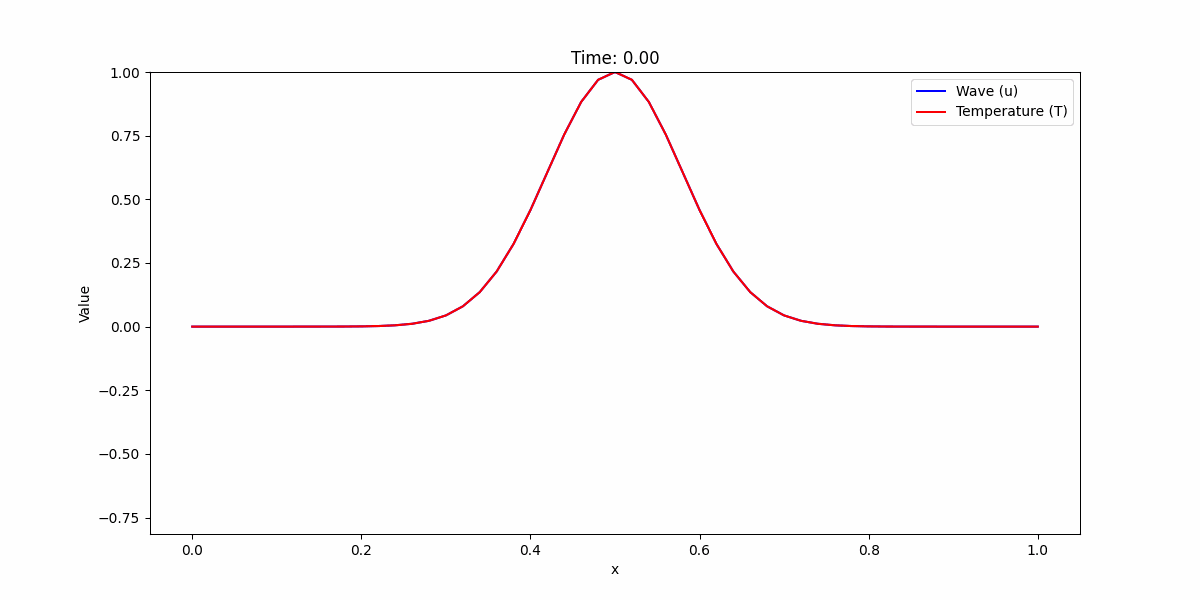

In [ ]:
# @title Neural Model for Wave Speed Correction Code


#-------------------------------------------------------------------------------
# NN SECTION

class WaveSpeedNN(tf.keras.Model):
    def __init__(self, hidden_dims):
        super(WaveSpeedNN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(dim, activation='relu') for dim in hidden_dims]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

def train_wave_speed_nn(T_train, c0_train, c_corr_train, hidden_dims=[64, 64], epochs=3, learning_rate=0.01):

    inputs = np.concatenate([T_train, c0_train], axis=-1)
    model = WaveSpeedNN(hidden_dims)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mse')

    # Train the model
    model.fit(inputs, c_corr_train, epochs=epochs, verbose=0)

    return model

def nn_workflow():

    # Training data

    np.random.seed(42)
    num_samples = 250

    # Generate random temperatures and c0
    T_train  = np.random.uniform(0, 1, size=(num_samples, 1))
    c0_train = np.random.uniform(0, 1, size=(num_samples, 1))

    # Define a nonlinear relationship for corrected wave speeds, just for example
    # For example: c_corr = c0 * (1 + 0.5 * T^2 + 0.1 * T^3)
    def nonlinear_relationship(T, c0):
        c_unorm = c0 * (1 + 0.5 * T**2 + 0.1 * T**3)
        c_max   = np.max(c_unorm)
        c_corr_norm = (c_unorm ) / (c_max)

        return c_corr_norm

    c_corr_train = nonlinear_relationship(T_train, c0_train)

    # Train the model workflow
    trained_model = train_wave_speed_nn(T_train, c0_train, c_corr_train)

    return trained_model

c_model = nn_workflow()

#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# SIMULATION SECTION

def sbp_matrix(N, h):
    """Constructs the SBP matrices D1 and D2 for a grid with N points and step size h."""
    e = np.ones(N)

    # First derivative D1 (2nd order)
    D1 = np.diag(-1*e[:-1], -1) + np.diag(e[:-1], 1)
    D1[0, 0] = -1; D1[0, 1] = 1; D1[-1, -2] = -1; D1[-1, -1] = 1
    D1 = D1 / (2 * h)

    # Second derivative D2 (2nd order)
    D2 = np.diag(-2*e) + np.diag(e[:-1], 1) + np.diag(e[:-1], -1)
    D2 = D2 / (h**2)

    # Weight matrix H for energy
    H = h * np.eye(N)

    return D1, D2, H

def wave_equation_system(u, p, c, D1, D2):
    """Computes the time derivatives for the wave equation system."""
    du_dt = p
    dp_dt = c**2 * (D2 @ u)

    return du_dt, dp_dt

def heat_equation_system(T, alpha, D2):
    """Computes the time derivatives for the heat equation system."""
    dT_dt = alpha * (D2 @ T)

    return dT_dt

def update_wave_speed(T, c0):
    """Updates the wave speed based on the temperature an c0 based on NN model."""

    c0_rep = np.repeat(c0, np.shape(T)[0]).reshape(-1,1)  # Reshape c0_rep to 2D
    #print(np.shape(c0_rep))
    simulation_input = np.concatenate([T.reshape(-1,1), c0_rep], axis=-1)  # Reshape T to 2D
    c_corr_sim = c_model.predict(simulation_input, verbose=0).flatten()   # Neural Model of c(T, c0)
    #print((c_corr))

    return c_corr_sim

def rk4_step_wave_heat(u, p, T, dt, c0, alpha, D1, D2, H, tau):
    """Performs one Runge-Kutta 4th order time step for coupled wave and heat equations."""
    c = update_wave_speed(T, c0)

    k1_u, k1_p = wave_equation_system(u, p, c, D1, D2)
    k1_u, k1_p = apply_sat(k1_u, k1_p, u, H, tau)

    k1_T = heat_equation_system(T, alpha, D2)

    u2 = u + 0.5 * dt * k1_u
    p2 = p + 0.5 * dt * k1_p
    T2 = T + 0.5 * dt * k1_T

    c2 = update_wave_speed(T2, c0)

    k2_u, k2_p = wave_equation_system(u2, p2, c2, D1, D2)
    k2_u, k2_p = apply_sat(k2_u, k2_p, u2, H, tau)

    k2_T = heat_equation_system(T2, alpha, D2)

    u3 = u + 0.5 * dt * k2_u
    p3 = p + 0.5 * dt * k2_p
    T3 = T + 0.5 * dt * k2_T

    c3 = update_wave_speed(T3, c0)

    k3_u, k3_p = wave_equation_system(u3, p3, c3, D1, D2)
    k3_u, k3_p = apply_sat(k3_u, k3_p, u3, H, tau)

    k3_T = heat_equation_system(T3, alpha, D2)

    u4 = u + dt * k3_u
    p4 = p + dt * k3_p
    T4 = T + dt * k3_T

    c4 = update_wave_speed(T4, c0)

    k4_u, k4_p = wave_equation_system(u4, p4, c4, D1, D2)
    k4_u, k4_p = apply_sat(k4_u, k4_p, u4, H, tau)

    k4_T = heat_equation_system(T4, alpha, D2)

    u_new = u + (dt/6) * (k1_u + 2*k2_u + 2*k3_u + k4_u)
    p_new = p + (dt/6) * (k1_p + 2*k2_p + 2*k3_p + k4_p)
    T_new = T + (dt/6) * (k1_T + 2*k2_T + 2*k3_T + k4_T)

    return u_new, p_new, T_new

def apply_sat(du_dt, dp_dt, u, H, tau):
    """Applies the SAT (Summation-By-Parts with Stabilization) method to enforce boundary conditions."""
    # Dirichlet condition at u(0,t) and u(L,t)
    du_dt[0]  = du_dt[0]  - tau * u[0]  / H[0,0]
    du_dt[-1] = du_dt[-1] - tau * u[-1] / H[-1,-1]

    # Set dp_dt to zero at the boundaries
    dp_dt[0]  = 0
    dp_dt[-1] = 0

    return du_dt, dp_dt

#-------------------------------------------------------------------------------

# Problem parameters
N    = 51  # Number of points in the grid
L    = 1.0  # Length of the domain
h    = L / (N-1)  # Spatial step size
c0   = 0.2   # Base wave speed coefficient
alpha = 0.01  # Thermal diffusivity

tau  = 0.1  # SAT parameter
dt   = 0.01
T_f  = 1  # Final time

# Compute SBP matrices
D1, D2, H = sbp_matrix(N, h)

# Spatial grid
x = np.linspace(0, L, N)

# Initial conditions
mean = 0.5  # Center of the Gaussian
std_dev = 0.08  # Standard deviation of the Gaussian
u = np.exp(-((x - mean)**2) / (2 * std_dev**2))
p = np.zeros(N)  # Initial velocity
T = np.exp(-((x - mean)**2) / (2 * std_dev**2))  # Initial temperature

#-------------------------------------------------------------------------------

# List to save the time history
history_u = []
history_T = []

# Time integration
t = 0
while t < T_f:
    history_u.append(u.copy())  # Save the current wave solution
    history_T.append(T.copy())  # Save the current temperature solution
    u, p, T = rk4_step_wave_heat(u, p, T, dt, c0, alpha, D1, D2, H, tau)
    t += dt


np.savez('coupled_NN_simulation_history.npz', x=x, history_u=np.array(history_u), history_T=np.array(history_T))

show_history('coupled_simulation_history.npz', step=50, name='coupled_NN_simulation')
Image(filename='coupled_NN_simulation.gif')
